In [2]:
import nltk
nltk.download('wordnet')

import re
import string
import datetime
from collections import Counter

import pickle

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction import text 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings 
warnings.simplefilter('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/darienmitchelltontar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load the data and set index

In [2]:
dtm1_plain = pd.read_pickle('./pickles/plain_df.pkl')
df_plain = pd.read_pickle('./pickles/unstemmed_df.pkl')

In [3]:
dtm1_plain.reset_index(inplace=True)

## Function to group dataframe by quarters

In [4]:
def quarters(dataframe):
    
    dataframe.Date = pd.to_datetime(dataframe.Date)
    
    dataframe.index = dataframe.Date
    
    dataframe.drop('Date', axis=1, inplace=True)
    
    return dataframe.resample('3M').sum()
    

### Pickle the quarters function

In [5]:
with open('./pickles/dataframe_to_quarters.pkl', 'wb') as f:
    pickle.dump(quarters, f)

## Break dataframe up into quarters

### Break document term matrix into quarters

In [6]:
dtm1_qrt = quarters(dtm1_plain).transpose()

### Break letters dataframe into quarters

In [7]:
leters_qrt = quarters(df_plain)

In [8]:
# drop the location column too since it doesnt really make sense here
leters_qrt.drop('Location', axis=1, inplace=True)

### Pickle the dataframe

In [9]:
leters_qrt.to_pickle('./pickles/letters_grouped_by_qrt.pkl')

## Finding top words per quarter

In [10]:
# Collecting the top words in each quarter

top_dict = {}

for quarter in dtm1_qrt.columns:
    
    top = dtm1_qrt[quarter].sort_values(ascending=False).head(30)
    top_dict[quarter]= list(zip(top.index, top.values))


In [11]:
# Find the top 30 words for each quarter
words = []
for quarter in dtm1_qrt.columns:
    top = [word for (word, count) in top_dict[quarter]]
    for t in top:
        words.append(t)
    

### Additional stop words

In [12]:
add_stop_words = [word for word, count in Counter(words).most_common() if count > 7]

custom_stop_words = ['saw', 'month', 'year', 'week', 'read', 'new', 'soon', 'hour', 'feel', 'reading', 'make',
                    'write', 'wish', 'getting', 'waiting', 'want', 'to', 'way', 've', 'wa', 'ha']

In [13]:
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words, custom_stop_words)

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

### Pickle this list of stop words

In [14]:
with open('./pickles/stop_words_list.pkl', 'wb') as f:
    pickle.dump(stop_words, f)

## Word cloud for each quarter

### Bring in sentiment score Dataframe

In [15]:
df_qrt_sentiment = pd.read_pickle('./pickles/letter_sentiment_by_qrt.pkl')

### Plot word cloud

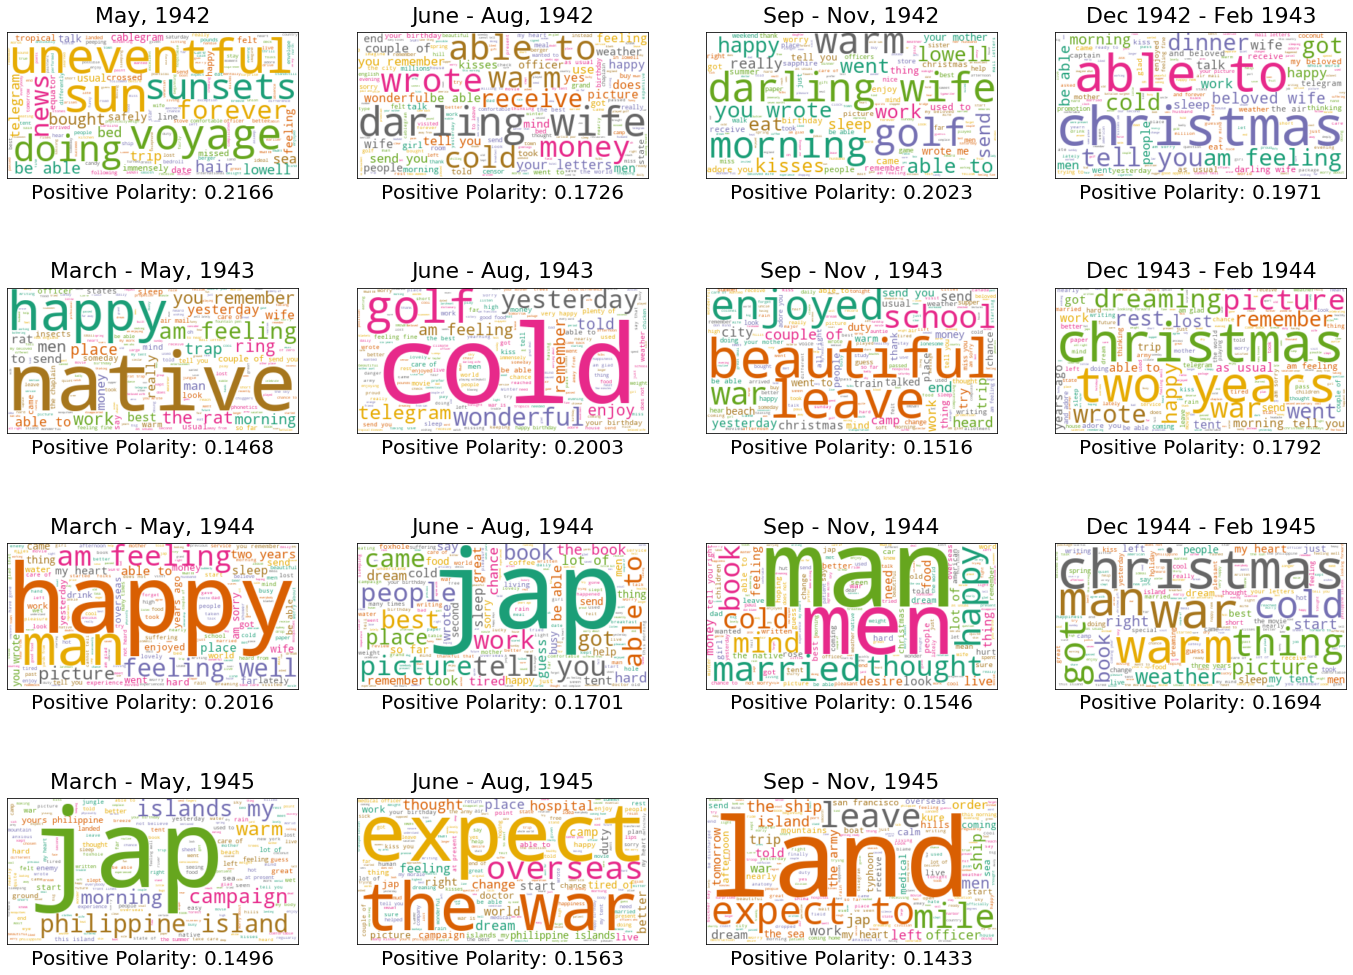

In [16]:

plt.rcParams['figure.figsize'] = [24, 18]

# the quarterly periods
periods = ['May, 1942', 'June - Aug, 1942', 'Sep - Nov, 1942', 'Dec 1942 - Feb 1943',
           'March - May, 1943', 'June - Aug, 1943', 'Sep - Nov , 1943', 'Dec 1943 - Feb 1944',
           'March - May, 1944', 'June - Aug, 1944', 'Sep - Nov, 1944', 'Dec 1944 - Feb 1945',
           'March - May, 1945', 'June - Aug, 1945', 'Sep - Nov, 1945']

# Create subplots for each quarter
for index, period in enumerate(leters_qrt.index):
    wc.generate(leters_qrt['Letter'].loc[period])
    
    plt.subplot(4, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.title(periods[index], fontsize=22, pad=10)
    plt.xlabel('Positive Polarity: ' + str(round(df_qrt_sentiment['positive'].iloc[index], 4)), fontsize=20,labelpad=5)
    
    plt.tick_params(
        axis='both',          
        which='both',      
        bottom=False,      
        top=False,
        left=False,         
        labelbottom=False,
        labelleft=False)
    
plt.show()

## Most common words by month

In [17]:
months = dtm1_plain.groupby(dtm1_plain.index.map(lambda x: x.month)).sum()
months = months.transpose()

In [18]:
letters_by_month = df_plain.groupby(df_plain.index.map(lambda x: x.month))['Letter'].sum()

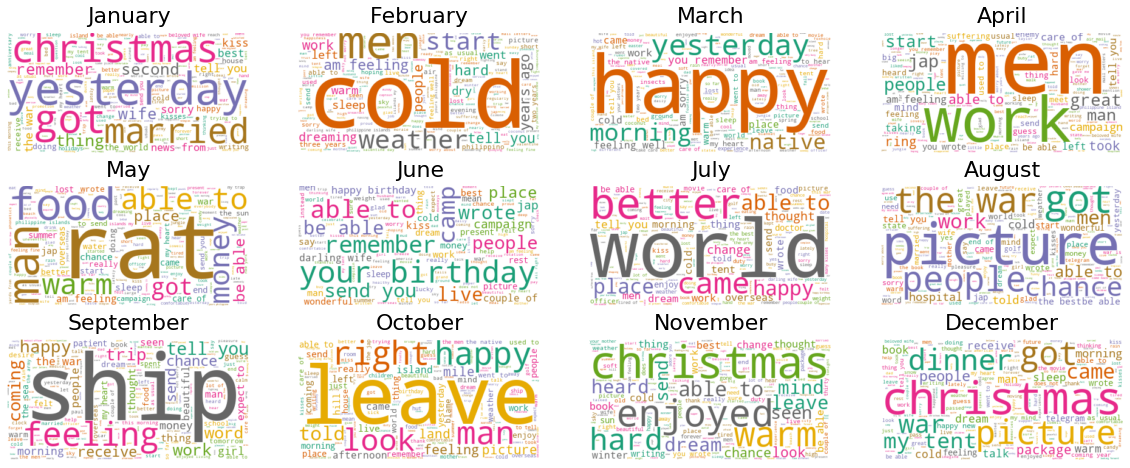

In [19]:

plt.rcParams['figure.figsize'] = [20, 8]

letter_months = ['January', 'February', 'March', 'April', 'May', 'June', 
                 'July', 'August', 'September', 'October', 'November', 'December']

# Create subplots for each month
for index in letters_by_month.index:
    wc.generate(letters_by_month.loc[index])
    
    plt.subplot(3, 4, index)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(letter_months[index-1], fontsize=22, pad=10)
    
plt.show()

## By location

In [20]:
df_main_locations = df_plain[~df_plain.Location.isin(['Mindanao', 'Leyte', 'California', 'Okinawa'])]

In [21]:
### Group data by location for graphing

locations = df_main_locations.groupby('Location').sum()

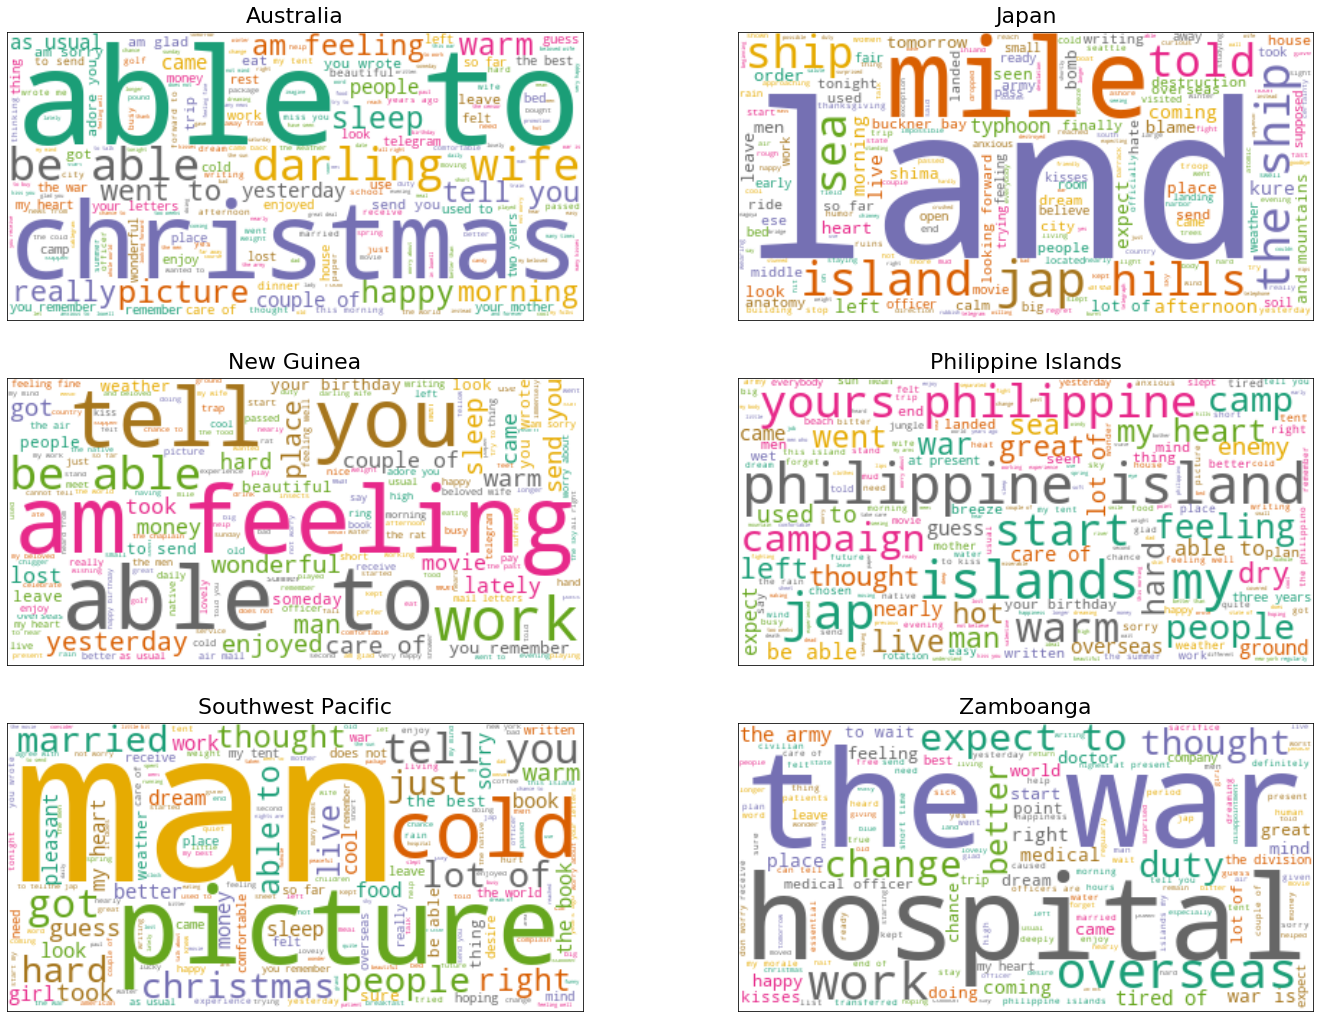

In [24]:
plt.rcParams['figure.figsize'] = [24, 18]

# the quarterly periods
periods = locations.index

# Create subplots for each quarter
for index, local in enumerate(locations.index):
    wc.generate(locations.loc[local][0])
    
    plt.subplot(3, 2, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.title(local, fontsize=22, pad=10)
    
    plt.tick_params(
        axis='both',          
        which='both',      
        bottom=False,      
        top=False,
        left=False,         
        labelbottom=False,
        labelleft=False)
    
plt.show()

## By most negative and most positive letters

In [25]:
pos_indices = ['1944-05-05',  '1943-02-24', '1943-07-02','1942-11-15', '1942-11-24',
              '1942-12-22', '1944-06-17', ]
neg_indices = ['1945-08-30', '1945-10-13', '1944-01-13', '1945-05-01',
               '1945-10-16', '1944-07-07', '1945-09-10', '1945-06-17',
               '1945-04-19', '1943-05-02']

In [26]:
df_plain.reset_index(inplace=True)

In [27]:
df_plain.index = pd.to_datetime(df_plain.Date)

In [28]:
neg_letters = df_plain.loc[pd.to_datetime(neg_indices)]

In [29]:
pos_letters = df_plain.loc[pd.to_datetime(pos_indices)]

In [31]:
neg_corpus = ''

for index in pd.to_datetime(neg_indices):
    neg_corpus += neg_letters.Letter.loc[index]


In [34]:
pos_corpus = ''

for index in pd.to_datetime(pos_indices):
    pos_corpus += pos_letters.Letter.loc[index][0]
    

In [37]:
new_stop_words = ['man', 'men', 'able', 'to', 'mile', 'people', 'feeling', 'glad', 'came']

stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words, custom_stop_words, new_stop_words)

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

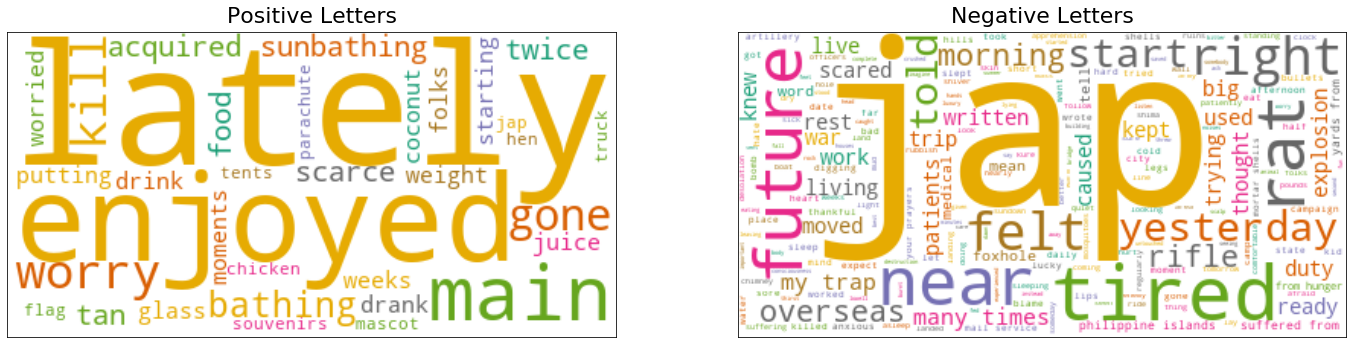

In [38]:
plt.rcParams['figure.figsize'] = [24, 18]

# the quarterly periods
titles = ['Positive Letters', 'Negative Letters']

# Create subplots for each quarter
for index, corpus in enumerate([pos_corpus, neg_corpus]):
    wc.generate(corpus)
    
    plt.subplot(1, 2, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.title(titles[index], fontsize=22, pad=10)
#     plt.xlabel('Positive Polarity: ' + str(df_qrt_sentiment['positive'].iloc[index]), fontsize=20,labelpad=5)
    
    plt.tick_params(
        axis='both',          
        which='both',      
        bottom=False,      
        top=False,
        left=False,         
        labelbottom=False,
        labelleft=False)
    
plt.show()

## Letters for blog/presentation

### Topic 1 Duty

In [ ]:
df_plain.Letter[df_plain.Date == '1945-07-31']

### Topic 2 Comfort/Normalization

In [ ]:
df_plain.Letter[df_plain.Date == '1942-10-19 ']

### Topic 4 Inner Conflict/Struggle

In [ ]:
df_plain.Letter[df_plain.Date == '1945-04-09']

### Romance

In [ ]:
df_plain.Letter[df_plain.Date == '1943-04-18']